# 3W Dataset Processing & Scaling Methods

This notebook demonstrates efficient data preprocessing techniques using the **3W dataset** - a comprehensive dataset for fault detection in oil wells.

## Overview
- **Centralized Configuration**: All parameters managed in `src/config.py` 
- **Data loading and preprocessing** using modular toolkit
- **Multiple scaling methods** comparison (StandardScaler, MinMaxScaler, RobustScaler, Normalizer)
- **Smart cross-validation** with real/simulated data separation
- **Time windowing** for sequence-based models
- **Comprehensive visualizations** for data analysis

## Key Features
- ✅ **No hard-coded values** - all configuration centralized
- 🔧 **Modular design** - reusable components in `src/` folder
- 📊 **Config-driven processing** - easy parameter adjustment
- 🎯 **Cross-validation utilities** - specialized for 3W dataset

---

In [1]:
# Import Our Methods
import os

from src import DataLoader, DataPreprocessor, DataVisualizer, CrossValidator
from src import config

print("\n🚀 3W Dataset Processing Methods Loaded")
print("=" * 50)
print(f"📋 Configuration loaded from: src/config.py")
print(f"   • Target features: {config.TARGET_FEATURES}")
print(f"   • Default scaling: {config.DEFAULT_SCALING_METHOD}")
print(f"   • Cross-validation: {config.N_FOLDS} folds")
print(f"   • Window size: {config.WINDOW_SIZE}")
print(f"   • Random seed: {config.RANDOM_SEED}")


🚀 3W Dataset Processing Methods Loaded
📋 Configuration loaded from: src/config.py
   • Target features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']
   • Default scaling: minmax
   • Cross-validation: 3 folds
   • Window size: 300
   • Random seed: 42


📊 Step 1: Loading Dataset with Real/Simulated Separation
📁 Dataset Structure:
Class 0: 594 parquet files
  └── Real data: 594 files
  └── Simulated data: 0 files

Class 1: 128 parquet files
  └── Real data: 4 files
  └── Simulated data: 124 files

Class 2: 38 parquet files
  └── Real data: 22 files
  └── Simulated data: 16 files

Class 3: 106 parquet files
  └── Real data: 32 files
  └── Simulated data: 74 files

Class 4: 343 parquet files
  └── Real data: 343 files
  └── Simulated data: 0 files

Class 5: 450 parquet files
  └── Real data: 11 files
  └── Simulated data: 439 files

Class 6: 221 parquet files
  └── Real data: 6 files
  └── Simulated data: 215 files

Class 7: 46 parquet files
  └── Real data: 36 files
  └── Simulated data: 10 files

Class 8: 95 parquet files
  └── Real data: 14 files
  └── Simulated data: 81 files

Class 9: 207 parquet files
  └── Real data: 57 files
  └── Simulated data: 150 files

Total classes found: 10
Classes: ['0', '1', '2', '3', '4', '5', '6', '7',

Processing classes:   0%|          | 0/10 [00:00<?, ?it/s]

Debug - File: WELL-00001_20170201010207.parquet
  Shape: (21474, 29)
  Columns: ['ABER-CKGL', 'ABER-CKP', 'ESTADO-DHSV', 'ESTADO-M1', 'ESTADO-M2', 'ESTADO-PXO', 'ESTADO-SDV-GL', 'ESTADO-SDV-P', 'ESTADO-W1', 'ESTADO-W2', 'ESTADO-XO', 'P-ANULAR', 'P-JUS-BS', 'P-JUS-CKGL', 'P-JUS-CKP', 'P-MON-CKGL', 'P-MON-CKP', 'P-MON-SDV-P', 'P-PDG', 'PT-P', 'P-TPT', 'QBS', 'QGL', 'T-JUS-CKP', 'T-MON-CKP', 'T-PDG', 'T-TPT', 'class', 'state']
  Has 'class' column: True


  ✅ Successfully loaded: 17874 samples
Debug - File: WELL-00001_20170201060114.parquet
  Shape: (21527, 29)
  Columns: ['ABER-CKGL', 'ABER-CKP', 'ESTADO-DHSV', 'ESTADO-M1', 'ESTADO-M2', 'ESTADO-PXO', 'ESTADO-SDV-GL', 'ESTADO-SDV-P', 'ESTADO-W1', 'ESTADO-W2', 'ESTADO-XO', 'P-ANULAR', 'P-JUS-BS', 'P-JUS-CKGL', 'P-JUS-CKP', 'P-MON-CKGL', 'P-MON-CKP', 'P-MON-SDV-P', 'P-PDG', 'PT-P', 'P-TPT', 'QBS', 'QGL', 'T-JUS-CKP', 'T-MON-CKP', 'T-PDG', 'T-TPT', 'class', 'state']
  Has 'class' column: True
  ✅ Successfully loaded: 17927 samples


Processing classes: 100%|██████████| 10/10 [04:17<00:00, 25.76s/it]



📊 Loading Summary:
Total files processed: 2228
Successfully loaded: 2228 files
Real data files: 1119
Simulated data files: 1109
Empty/invalid files: 0
Total samples: 72,558,918

📊 Total loaded: 2228 dataframes
🧪 Implementing real/simulated separation based on data patterns...
📈 Real files in structure: 1119
🖥️ Simulated files in structure: 1109

✅ Dataset loaded successfully:
   • Total dataframes: 2228
   • Unique classes: 10
   • Class distribution: {'0': 594, '1': 128, '2': 38, '3': 106, '4': 343, '5': 450, '6': 221, '7': 46, '8': 95, '9': 207}
   • Note: Real/simulated separation will be done in train/test split step
🔍 Dataset Analysis
Total number of dataframes: 2228
Class distribution: Counter({'0': 594, '5': 450, '4': 343, '6': 221, '9': 207, '1': 128, '3': 106, '8': 95, '7': 46, '2': 38})


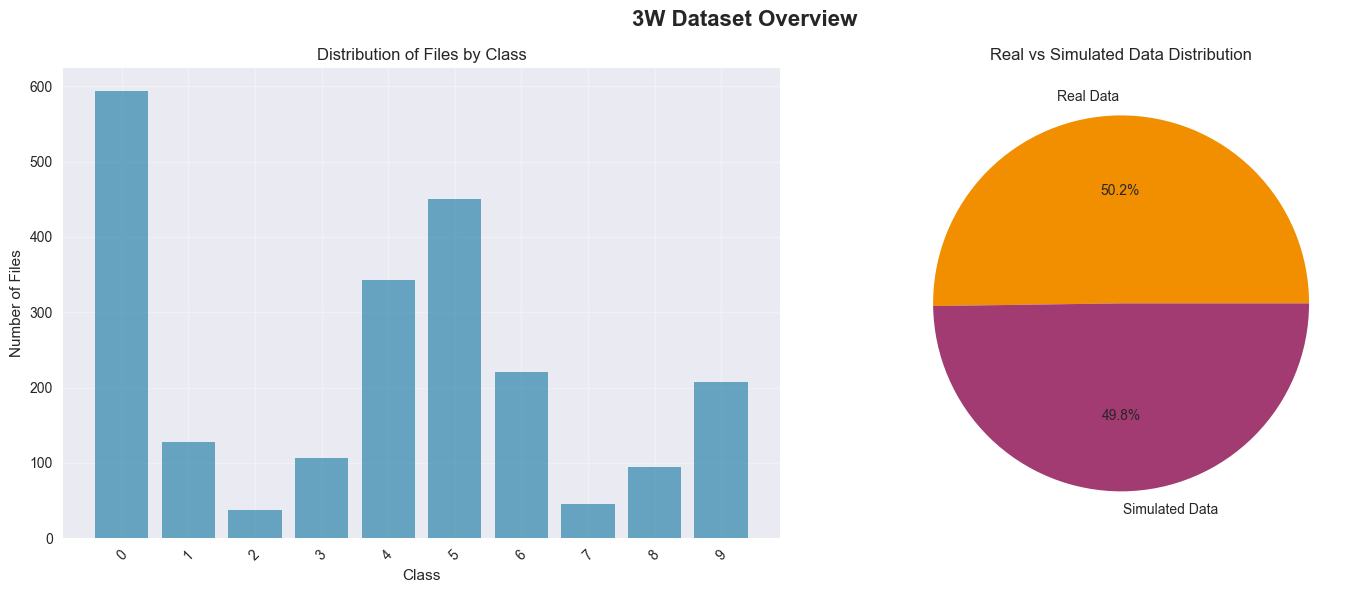

\n💾 Total samples: 72,558,918


In [2]:
# Step 1: Load and Explore Dataset with Real/Simulated Separation
print("📊 Step 1: Loading Dataset with Real/Simulated Separation")
print("=" * 60)

# Import required modules
from collections import Counter

# Initialize components
loader = DataLoader()
preprocessor = DataPreprocessor()
visualizer = DataVisualizer()

# Explore dataset structure
structure_info = loader.explore_structure()

# Load dataset (all available classes)
available_classes = structure_info.get("classes", [])
class_subset = available_classes  # Use all classes instead of subset

print(f"\n🎯 Loading all {len(class_subset)} classes: {class_subset}")
print("🔍 Separating real and simulated data during loading...")

# Load all data first
dfs_all, classes_all, stats_all = loader.load_dataset(class_subset)

# Now we need to separate based on the data characteristics
# Since the loader doesn't currently track file sources, we'll implement separation logic
print(f"\n📊 Total loaded: {len(dfs_all)} dataframes")
print(f"🧪 Implementing real/simulated separation based on data patterns...")

# For now, we'll use the structure info to understand the data better
# In a real implementation, you'd modify the DataLoader to track file sources
print(f"📈 Real files in structure: {structure_info.get('real_files', 'Unknown')}")
print(
    f"🖥️ Simulated files in structure: {structure_info.get('simulated_files', 'Unknown')}"
)

# Store all data for later separation in the train/test split step
dfs = dfs_all
classes = classes_all
stats = stats_all

print(f"\n✅ Dataset loaded successfully:")
print(f"   • Total dataframes: {len(dfs)}")
print(f"   • Unique classes: {len(set(classes))}")
print(f"   • Class distribution: {dict(Counter(classes))}")
print(f"   • Note: Real/simulated separation will be done in train/test split step")

# Show overview
visualizer.plot_dataset_overview(classes, stats)

## 📊 Step 1: Dataset Loading and Exploration

Load the 3W dataset, explore its structure, and get an overview of the available classes and file distribution.

In [3]:
# Step 2: Filter to Key Sensor Features
print("🔍 Step 2: Filtering Key Features")
print("=" * config.SEPARATOR_LENGTH)

# Focus on pressure and temperature sensors using config
target_features = config.TARGET_FEATURES
filtered_dfs, filtered_classes = loader.filter_target_features(
    dfs, classes, target_features
)

print(f"✅ Filtered to {len(filtered_dfs)} dataframes with key sensor data")
print(f"📋 Target features from config: {target_features}")

# Get dataset information
dataset_info = loader.get_dataset_info(filtered_dfs, filtered_classes)
print(f"\n📋 Dataset Summary:")
for key, value in dataset_info.items():
    print(f"   {key}: {value}")

🔍 Step 2: Filtering Key Features
🔍 Filtering Data to Key Sensor Variables
Target features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']

📄 DataFrame 1 (Class 0):
  Available features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']
  Shape after filtering: (17874, 4)
  Missing values per column:
    P-PDG: 0 (0.0%)
    P-TPT: 0 (0.0%)
    T-TPT: 0 (0.0%)
    class: 0 (0.0%)

📄 DataFrame 2 (Class 0):
  Available features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']
  Shape after filtering: (17927, 4)
  Missing values per column:
    P-PDG: 0 (0.0%)
    P-TPT: 0 (0.0%)
    T-TPT: 0 (0.0%)
    class: 0 (0.0%)

📄 DataFrame 3 (Class 0):
  Available features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']
  Shape after filtering: (17917, 4)
  Missing values per column:
    P-PDG: 0 (0.0%)
    P-TPT: 0 (0.0%)
    T-TPT: 0 (0.0%)
    class: 0 (0.0%)

📊 Filtering Results:
Datasets after filtering: 1714
Total samples: 58,750,728

🎯 Feature Availability Across Datasets:
----------------------------------------
P-PDG: 1714/1714 data

## 🔍 Step 2: Feature Filtering

Filter the dataset to focus on key sensor variables relevant for fault detection analysis.

📈 Step 3: Raw Data Analysis
🎯 Selected: DataFrame 1310, Class 5
   Sample size: 29299 data points
   Using config: min_samples=100
\n🔸 Plotting Raw Data Analysis...


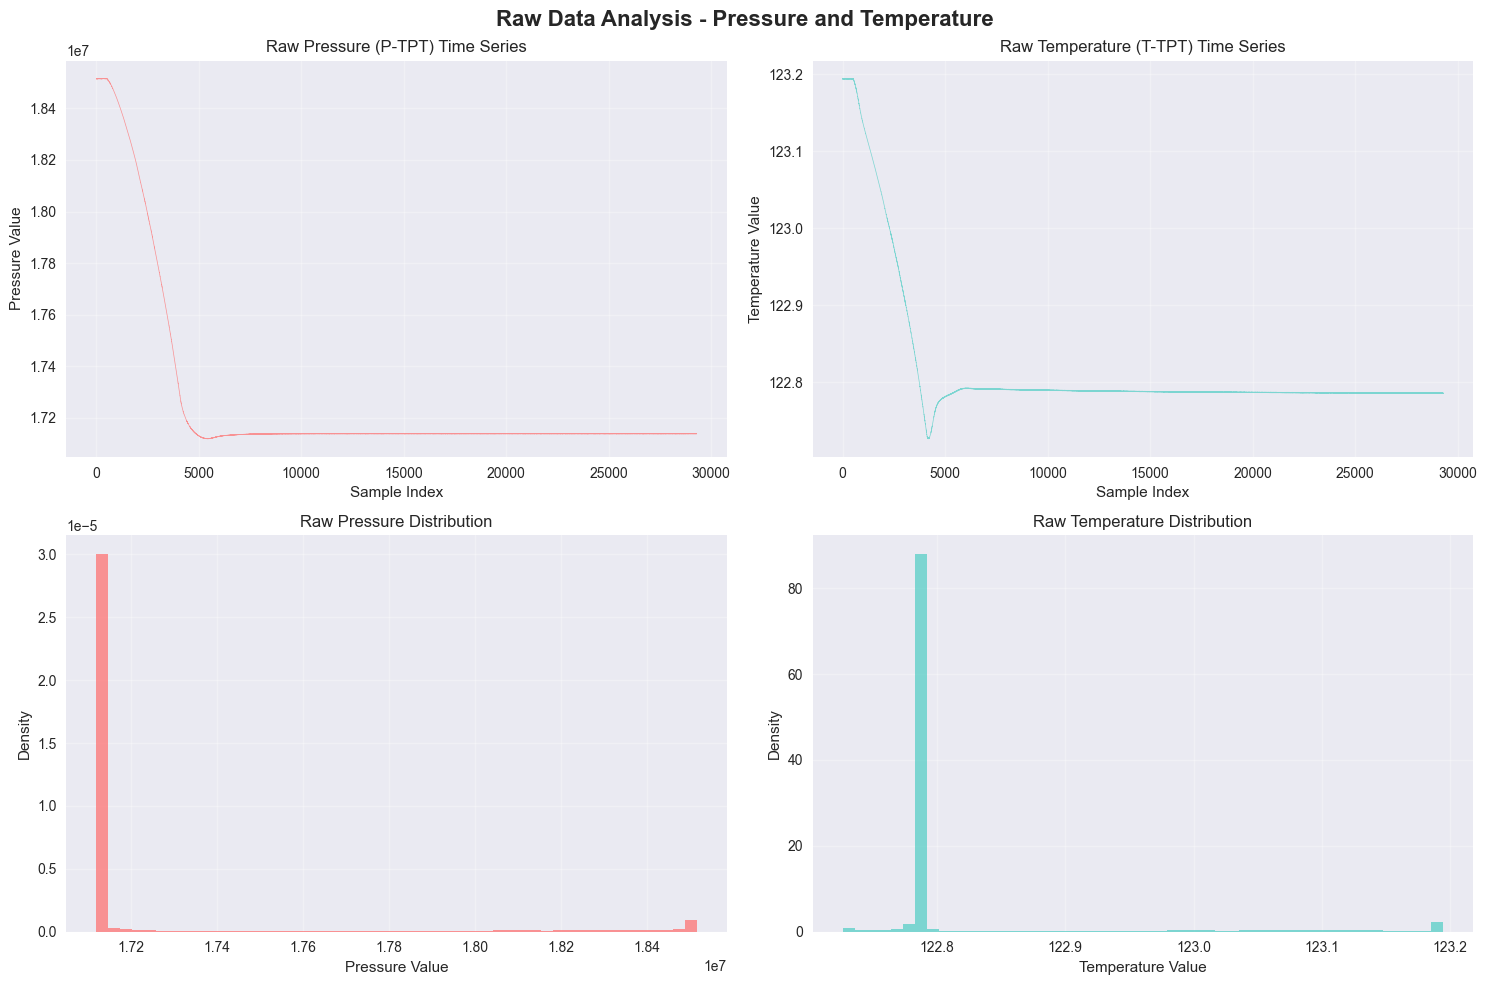

\n📈 Data Statistics:
Shape: (29299, 2)
              P-TPT         T-TPT
count  2.929900e+04  29299.000000
mean   1.727018e+07    122.818173
std    3.544496e+05      0.093910
min    1.711925e+07    122.726505
25%    1.713844e+07    122.786292
50%    1.713867e+07    122.787425
75%    1.713929e+07    122.789900
max    1.851547e+07    123.194485


In [4]:
# Step 3: Raw Data Analysis
print("📈 Step 3: Raw Data Analysis")
print("=" * config.SEPARATOR_LENGTH)

# Select random sample for detailed analysis using config values
try:
    idx, sample_df, class_label, sample_count = preprocessor.select_random_dataframe(
        filtered_dfs,
        filtered_classes,
        required_columns=config.REQUIRED_COLUMNS,
        min_samples=config.SAMPLE_ANALYSIS_MIN_SAMPLES,
    )

    print(f"🎯 Selected: DataFrame {idx + 1}, Class {class_label}")
    print(f"   Sample size: {sample_count} data points")
    print(f"   Using config: min_samples={config.SAMPLE_ANALYSIS_MIN_SAMPLES}")

    # Plot raw data analysis using config column names
    visualizer.plot_raw_data_analysis(
        sample_df, config.PRESSURE_COLUMN, config.TEMPERATURE_COLUMN
    )

except ValueError as e:
    print(f"⚠️ {e}")
    print("Using first available dataframe...")
    sample_df = filtered_dfs[0]
    class_label = filtered_classes[0]
    visualizer.plot_raw_data_analysis(
        sample_df, config.PRESSURE_COLUMN, config.TEMPERATURE_COLUMN
    )

## 📊 Step 3: Data Scaling Methods
Apply different scaling methods to normalize the data and compare their effects on the sensor measurements.


⚙️ Step 4: Scaling Methods Comparison
📊 Scaling Results:

StandardScaler:
  Pressure - Range: [-0.4258, 3.5134]
  Temperature - Range: [-0.9761, 4.0072]

MinmaxScaler:
  Pressure - Range: [0.0000, 1.0000]
  Temperature - Range: [0.0000, 1.0000]

RobustScaler:
  Pressure - Range: [-22.8663, 1620.9599]
  Temperature - Range: [-16.8831, 112.8111]

NormalizerScaler:
  Pressure - Range: [0.5752, 0.5786]
  Temperature - Range: [0.0000, 0.0000]
\n🔸 Plotting StandardScaler Analysis...


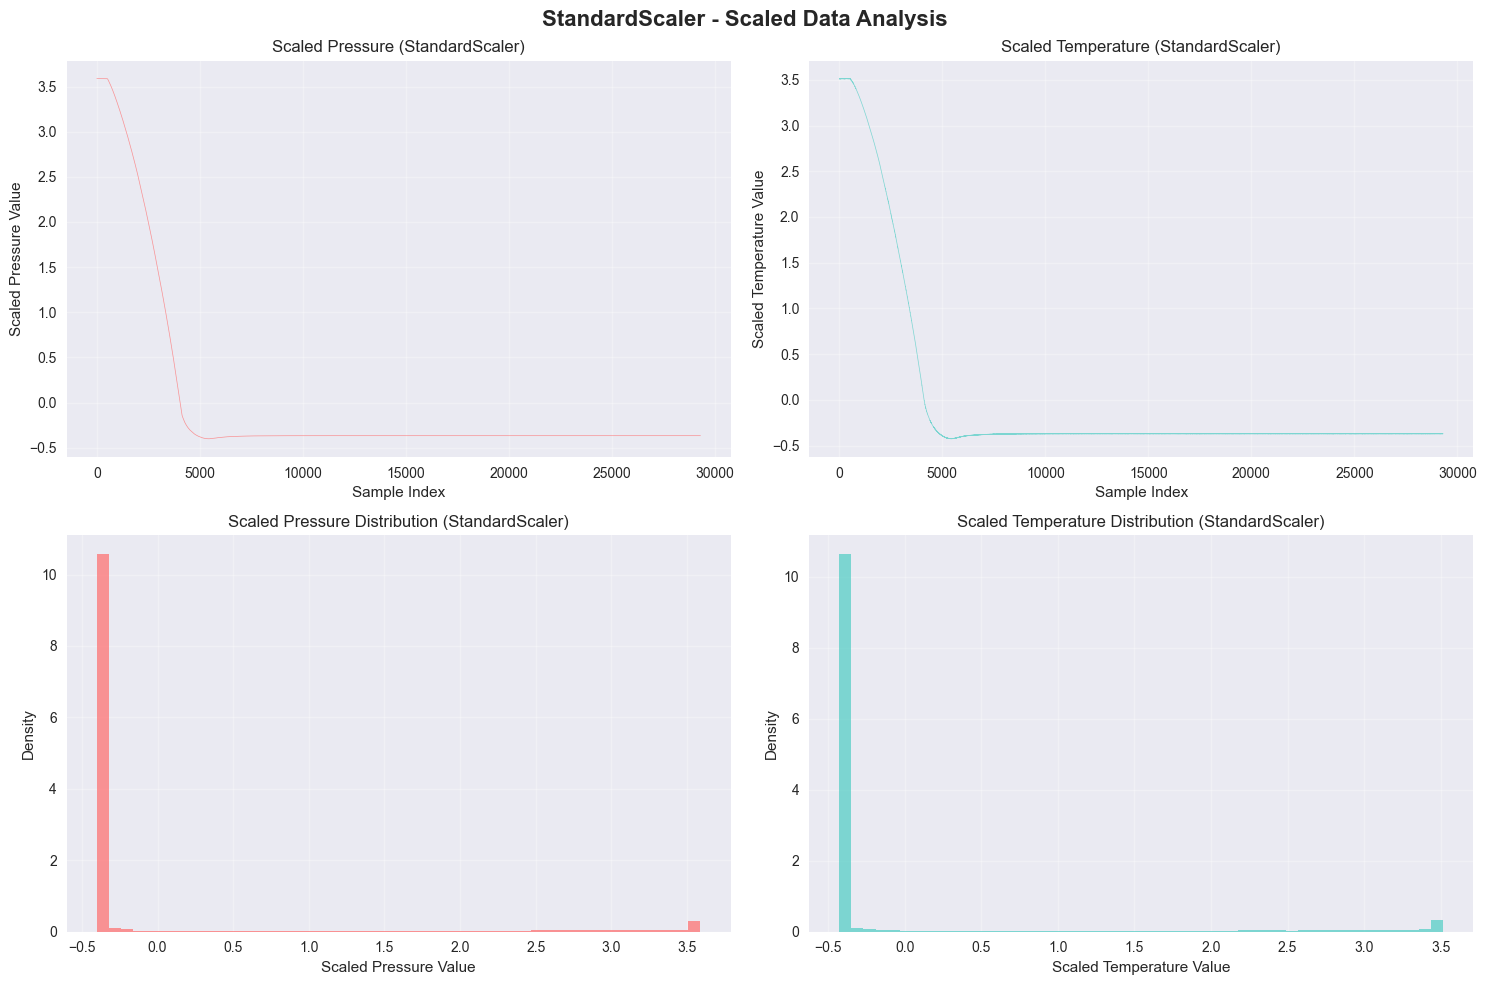

Statistics for StandardScaler:
Pressure - Mean: -0.0000, Std: 1.0000
Temperature - Mean: 0.0000, Std: 1.0000
\n🔸 Plotting MinmaxScaler Analysis...


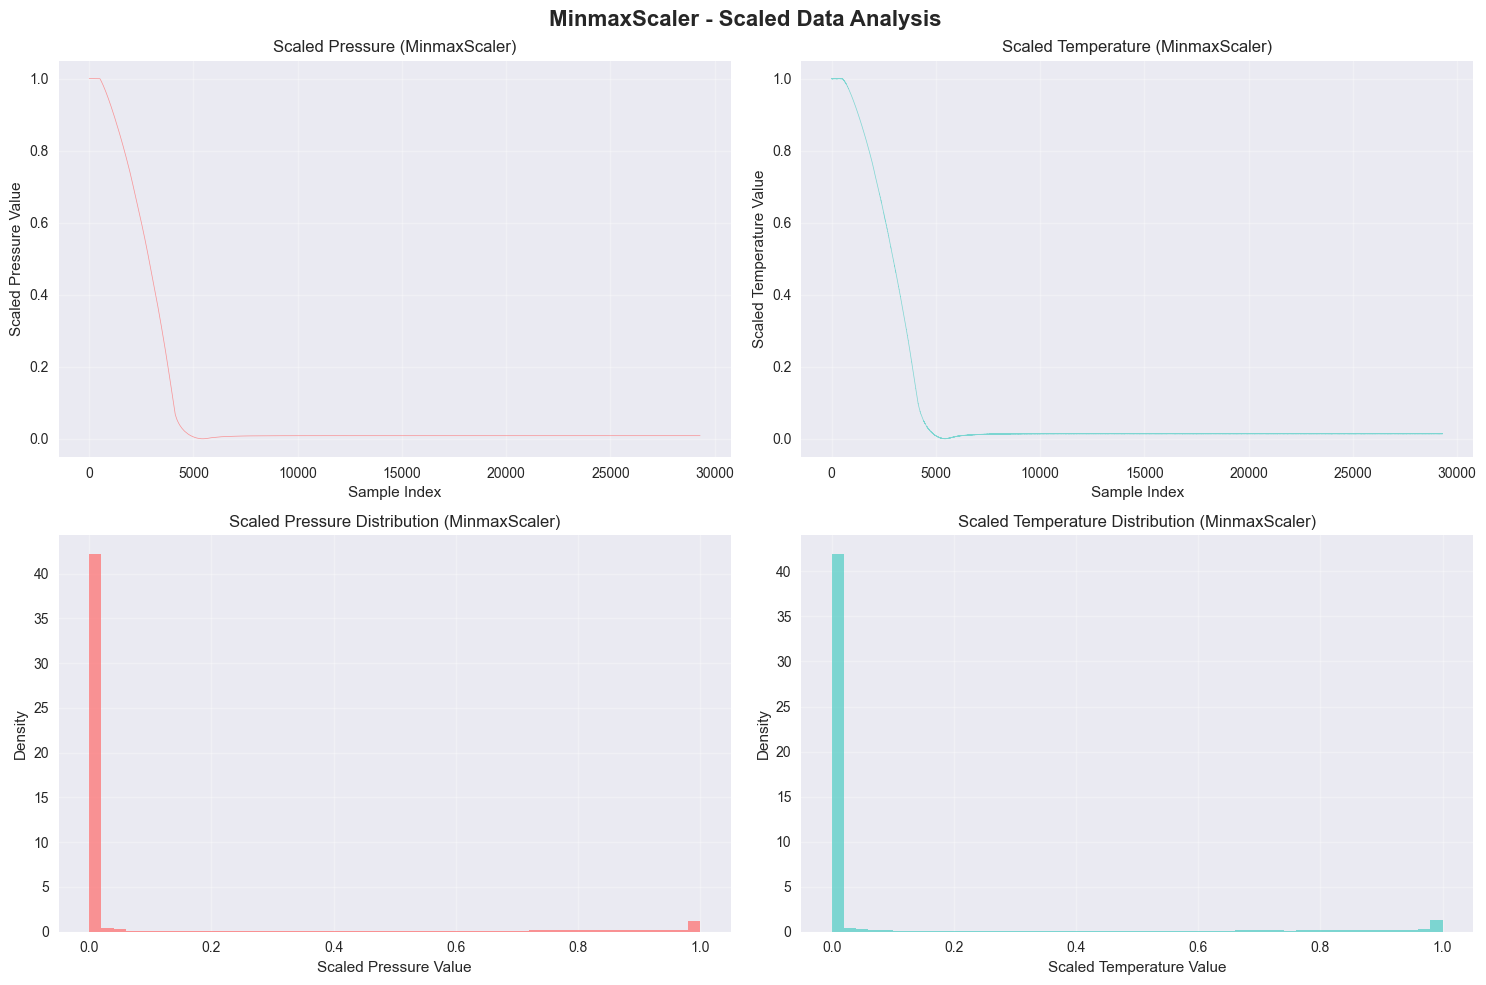

Statistics for MinmaxScaler:
Pressure - Mean: 0.1006, Std: 0.2506
Temperature - Mean: 0.1081, Std: 0.2539
\n🔸 Plotting RobustScaler Analysis...


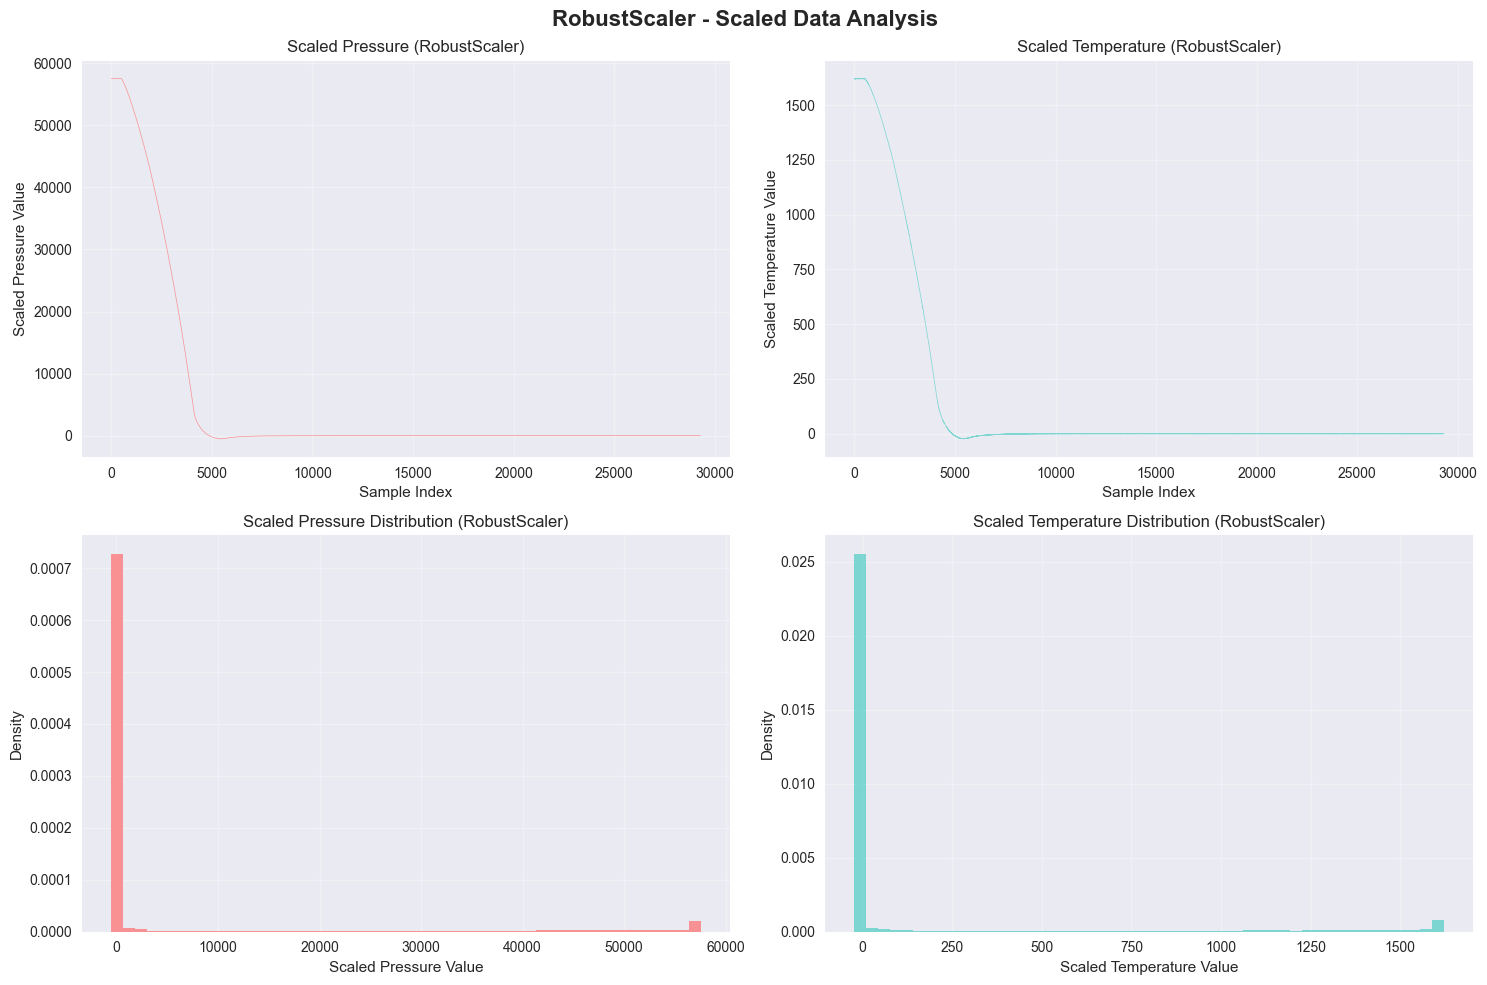

Statistics for RobustScaler:
Pressure - Mean: 5335.4523, Std: 14540.8818
Temperature - Mean: 154.8344, Std: 417.3063
\n🔸 Plotting NormalizerScaler Analysis...


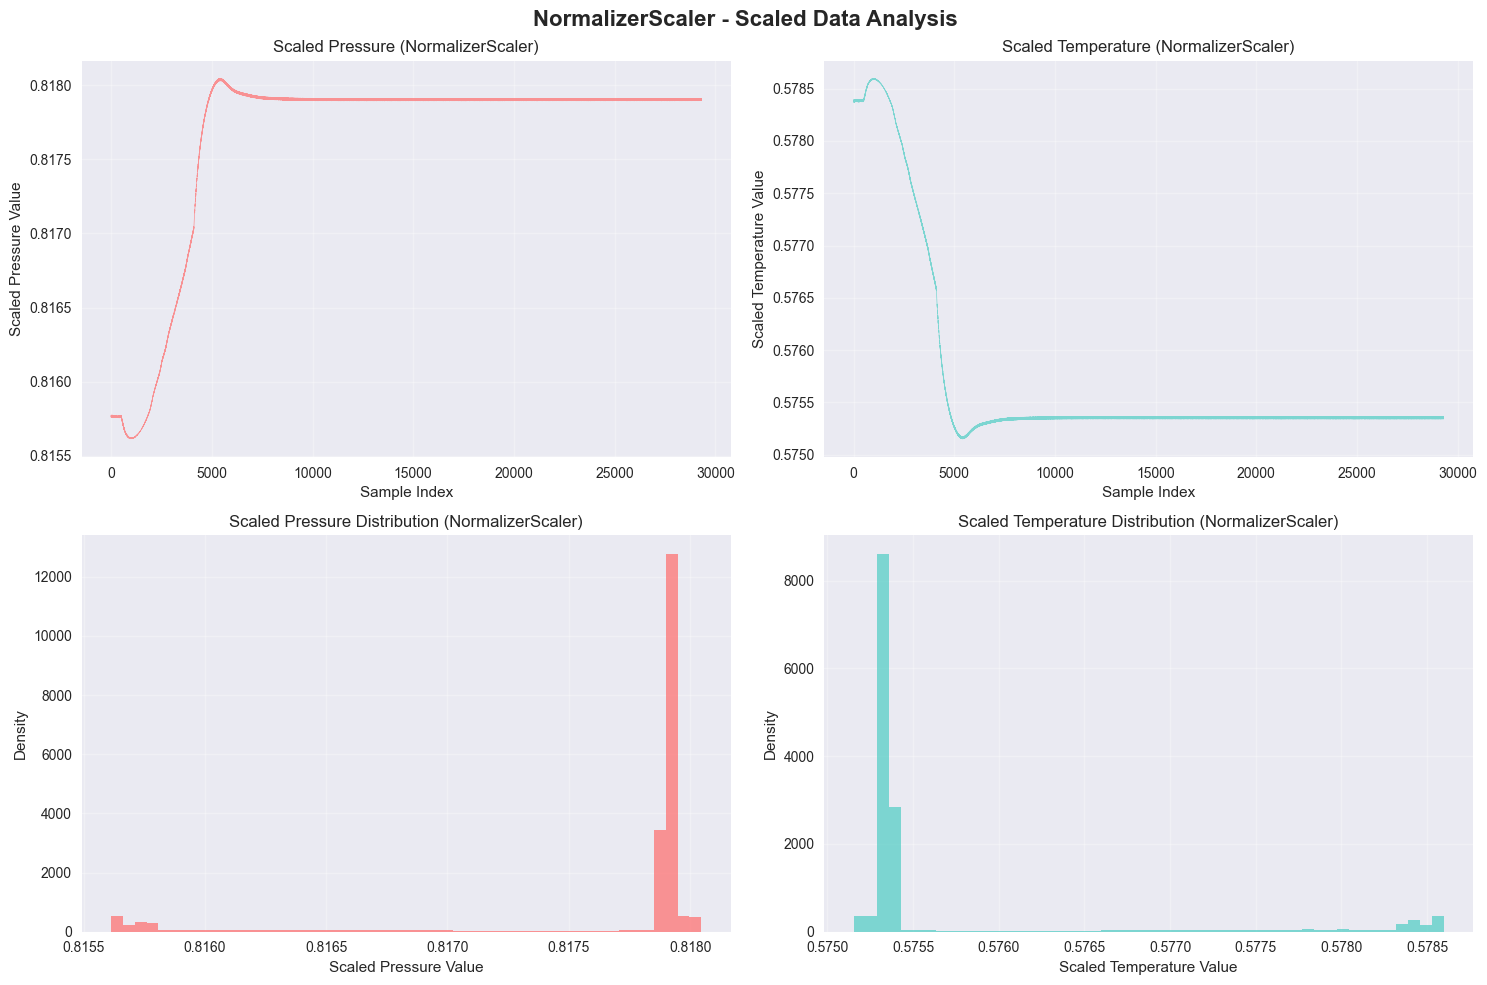

Statistics for NormalizerScaler:
Pressure - Mean: 0.8176, Std: 0.0007
Temperature - Mean: 0.5757, Std: 0.0009
\n🔸 Creating scaling comparison plots...


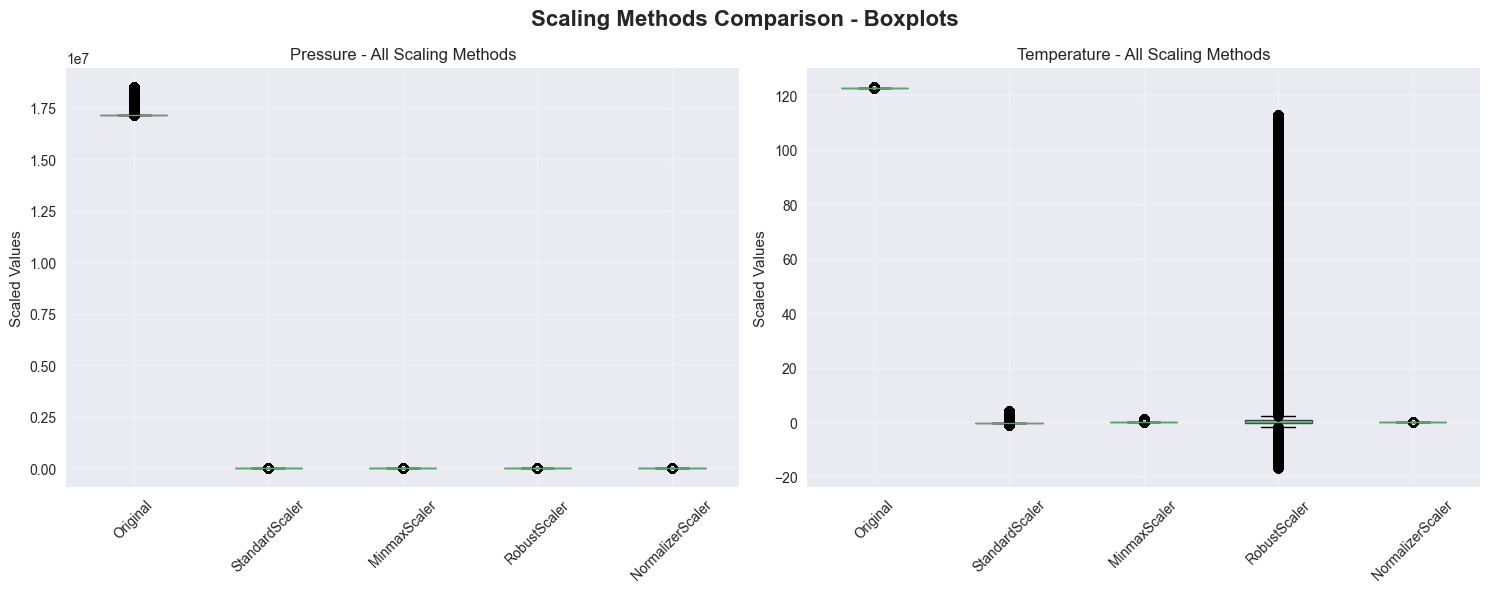

In [5]:
# Step 4: Scaling Methods Comparison
print("⚙️ Step 4: Scaling Methods Comparison")
print("=" * config.SEPARATOR_LENGTH)

# Apply all scaling methods to sample data
scaling_results = preprocessor.apply_multiple_scalers(sample_df)

# Display scaling statistics using config column names
print("📊 Scaling Results:")
for method_name, scaled_data in scaling_results.items():
    if method_name != "Original":
        numeric_cols = [
            col for col in scaled_data.columns if col != config.CLASS_COLUMN
        ]
        if numeric_cols:
            pressure_col = (
                [col for col in numeric_cols if config.PRESSURE_COLUMN in col][0]
                if any(config.PRESSURE_COLUMN in col for col in numeric_cols)
                else numeric_cols[0]
            )
            temp_col = (
                [col for col in numeric_cols if config.TEMPERATURE_COLUMN in col][0]
                if any(config.TEMPERATURE_COLUMN in col for col in numeric_cols)
                else numeric_cols[1] if len(numeric_cols) > 1 else numeric_cols[0]
            )

            print(f"\n{method_name}:")
            print(
                f"  Pressure - Range: [{scaled_data[pressure_col].min():.4f}, {scaled_data[pressure_col].max():.4f}]"
            )
            if pressure_col != temp_col:
                print(
                    f"  Temperature - Range: [{scaled_data[temp_col].min():.4f}, {scaled_data[temp_col].max():.4f}]"
                )

# Visualize each scaling method
for method_name, scaled_data in scaling_results.items():
    if method_name != "Original":
        visualizer.plot_scaled_data_analysis(scaled_data, method_name)

# Create comparison plot using config column names
visualizer.plot_scaling_comparison(
    scaling_results, config.PRESSURE_COLUMN, config.TEMPERATURE_COLUMN
)

## ⚖️ Step 4: Apply MinMax Scaler



In [6]:
# Step 5: Apply MinMax Scaling to All Data
print("🔄 Step 5: Processing All Data with Configured Scaler")
print("=" * config.SEPARATOR_LENGTH)

# Apply scaling using config method
scaling_method = config.DEFAULT_SCALING_METHOD
print(f"📋 Using scaling method from config: {scaling_method}")

normalized_dfs, normalized_classes = preprocessor.apply_scaling(
    filtered_dfs, filtered_classes, method=scaling_method
)

# Validation
if normalized_dfs:
    sample_normalized = normalized_dfs[0]
    validation_results = preprocessor.validate_scaling(
        sample_normalized, scaling_method
    )

    print(f"\n✅ Successfully normalized {len(normalized_dfs)} dataframes")
    print(f"📊 Sample normalized data shape: {sample_normalized.shape}")
    print(
        f"🔍 Validation results: {all(validation_results['correct_scaling'].values())}"
    )
    print(f"⚙️ Scaling method applied: {scaling_method}")

    # Show sample of normalized data
    print(f"\n📋 Sample Normalized Data (first 3 rows):")
    print(sample_normalized.head(3))

    print(f"\n💾 Variables created:")
    print(f"   • normalized_dfs: {len(normalized_dfs)} normalized dataframes")
    print(f"   • normalized_classes: corresponding class labels")
    print(f"   • Scaling method: {scaling_method} (from config)")

else:
    print("❌ No data was successfully normalized")

🔄 Step 5: Processing All Data with Configured Scaler
📋 Using scaling method from config: minmax
🔄 Applying MinmaxScaler to All Dataframes
✅ DataFrame 1 (Class 0):
   Original shape: (17874, 4)
   Scaled shape: (17874, 4)
   Numeric columns scaled: ['P-PDG', 'P-TPT', 'T-TPT']
   Value ranges after scaling:
     P-PDG_scaled: [0.0000, 0.0000]
     P-TPT_scaled: [0.0000, 1.0000]
     T-TPT_scaled: [0.0000, 1.0000]

✅ DataFrame 2 (Class 0):
   Original shape: (17927, 4)
   Scaled shape: (17927, 4)
   Numeric columns scaled: ['P-PDG', 'P-TPT', 'T-TPT']
   Value ranges after scaling:
     P-PDG_scaled: [0.0000, 0.0000]
     P-TPT_scaled: [0.0000, 1.0000]
     T-TPT_scaled: [0.0000, 1.0000]

✅ DataFrame 3 (Class 0):
   Original shape: (17917, 4)
   Scaled shape: (17917, 4)
   Numeric columns scaled: ['P-PDG', 'P-TPT', 'T-TPT']
   Value ranges after scaling:
     P-PDG_scaled: [0.0000, 0.0000]
     P-TPT_scaled: [0.0000, 1.0000]
     T-TPT_scaled: [0.0000, 1.0000]

✅ DataFrame 4 (Class 0):
   

In [7]:
# Summary
print("📋 Summary & Scaling Methods Guide")
print("=" * 45)

# Print comprehensive scaling summary
visualizer.print_scaling_summary()

print(f"\n🎉 Processing Complete!")
print(
    f"✅ Loaded and processed {len(normalized_dfs) if 'normalized_dfs' in locals() else 0} dataframes"
)
print(f"📊 Data ready for machine learning algorithms")

print(f"🔧 Available Variables:")
print(f"   • filtered_dfs: Original filtered data")
print(f"   • normalized_dfs: MinMax scaled data [0,1]")
print(f"   • scaling_results: Comparison of all scaling methods")

📋 Summary & Scaling Methods Guide
\n📋 Scaling Methods Summary:
🔹 StandardScaler: Mean=0, Std=1 (assumes normal distribution)
🔹 MinMaxScaler: Scales to [0,1] range (preserves relationships)
🔹 RobustScaler: Uses median and IQR (robust to outliers)
🔹 Normalizer: Unit vector scaling (preserves direction)
\n💡 When to use each:
- StandardScaler: Normal data, algorithms that assume normality (SVM, Neural Networks)
- MinMaxScaler: Need bounded values, preserve zero, distance-based algorithms
- RobustScaler: Data with outliers, non-normal distributions
- Normalizer: When direction matters more than magnitude (text analysis, clustering)

🎉 Processing Complete!
✅ Loaded and processed 1714 dataframes
📊 Data ready for machine learning algorithms
🔧 Available Variables:
   • filtered_dfs: Original filtered data
   • normalized_dfs: MinMax scaled data [0,1]
   • scaling_results: Comparison of all scaling methods


## 🔀 Step 5: Smart Train-Test Split with Cross-Validation

**Strategy:**
- **Training**: Use ALL available data (real + simulated) for better model learning
- **Testing**: Use ONLY real data for realistic evaluation  
- **Cross-Validation**: Create multiple folds where real data is split for testing while all data is used for training
- **Configuration**: All parameters (folds, random state, etc.) are loaded from `src/config.py`

**Configuration from config.py:**
- **Number of folds**: `config.N_FOLDS` (default: 3)
- **Random state**: `config.CV_RANDOM_STATE` (default: 42)  
- **Split ratio**: ~67% of real data for training, ~33% for testing per fold

In [8]:
# ============================================================
# STEP 5: SMART TRAIN-TEST SPLIT WITH 3-FOLD CROSS-VALIDATION
# ============================================================
print("=" * config.HEADER_SEPARATOR_LENGTH)
print("STEP 5: SMART TRAIN-TEST SPLIT WITH 3-FOLD CROSS-VALIDATION")
print("=" * config.HEADER_SEPARATOR_LENGTH)

# ============================================================
# Step 5a: Initialize Cross-Validation System
# ============================================================
print("🔧 Step 5a: Initializing Cross-Validation System")
print("-" * config.SEPARATOR_LENGTH)

# Initialize the cross-validator using config values
print(f"📋 Cross-validation configuration:")
print(f"   • Number of folds: {config.N_FOLDS}")
print(f"   • Random state: {config.CV_RANDOM_STATE}")
print(f"   • Verbose mode: {config.CV_VERBOSE}")

cross_validator = CrossValidator(
    n_folds=config.N_FOLDS,
    random_state=config.CV_RANDOM_STATE,
    verbose=config.CV_VERBOSE,
)

# Set up complete cross-validation in one call
cv_folds, separated_data = cross_validator.setup_complete_cv(
    dfs=normalized_dfs, classes=normalized_classes, loader=loader
)

# Extract separated data for convenience
real_dfs, real_classes, simulated_dfs, simulated_classes = separated_data

print(f"\n✅ Cross-validation setup complete!")
print(f"   • Created {len(cv_folds)} cross-validation folds (from config)")
print(f"   • Real data: {len(real_dfs)} samples")
print(f"   • Simulated data: {len(simulated_dfs)} samples")

STEP 5: SMART TRAIN-TEST SPLIT WITH 3-FOLD CROSS-VALIDATION
🔧 Step 5a: Initializing Cross-Validation System
--------------------------------------------------
📋 Cross-validation configuration:
   • Number of folds: 3
   • Random state: 42
   • Verbose mode: True
🔍 Separating Real vs Simulated Data
--------------------------------------------------
📊 Enhanced Separation Results:
   Original - Real: 1119, Simulated: 1109
   Processed - Real: 860, Simulated: 854
   Real proportion: 50.22%
   Real data classes: {'0': 456, '1': 44, '2': 21, '3': 32, '4': 222, '5': 11, '6': 6, '7': 31, '8': 8, '9': 29}
   Simulated data classes: {'1': 84, '2': 16, '3': 74, '5': 439, '7': 10, '8': 81, '9': 150}

🎯 Creating 3-Fold Cross-Validation Splits
--------------------------------------------------
🔄 Creating 3 cross-validation folds...

📁 FOLD 1:
--------------------
   Training Set:
     • Real data: 573 samples
     • Simulated data: 854 samples
     • Total training: 1427 samples
     • Training clas

In [9]:
# ============================================================
# Step 5b: Cross-Validation Analysis and Utilities
# ============================================================
print(f"\n🎯 Step 5b: Cross-Validation Analysis")
print("-" * 50)

# Show detailed comparison across all folds
cross_validator.compare_all_folds(cv_folds)

# Show detailed summary for fold 1 as an example
cross_validator.print_fold_summary(1, cv_folds)

# For compatibility with downstream processing, set default fold (fold 1)
current_fold = cv_folds[0]
train_dfs = current_fold["train_dfs"]
train_classes = current_fold["train_classes"]
test_dfs = current_fold["test_dfs"]
test_classes = current_fold["test_classes"]

print(f"\n📌 Default split set to Fold 1 for downstream processing")
print(f"   • Use cross_validator.get_fold_data(fold_num, cv_folds) for other folds")
print(f"   • Available utility methods:")
print(f"     - get_fold_data(fold_number, cv_folds)")
print(f"     - print_fold_summary(fold_number, cv_folds)")
print(f"     - compare_all_folds(cv_folds)")


🎯 Step 5b: Cross-Validation Analysis
--------------------------------------------------

📊 COMPARISON ACROSS ALL 3 FOLDS:
Fold   Train Real   Train Sim    Test Real    Train%     Test%     
----------------------------------------------------------------------
1      573          854          287          66.6     % 33.4     %
2      573          854          287          66.6     % 33.4     %
3      574          854          286          66.7     % 33.3     %

📁 FOLD 1 SUMMARY:
------------------------------
Training Data:
  • Real samples: 573
  • Simulated samples: 854
  • Total training: 1427
  • Class distribution: {'0': 304, '1': 113, '2': 30, '3': 95, '4': 148, '5': 447, '6': 4, '7': 30, '8': 87, '9': 169}
Test Data (Real Only):
  • Test samples: 287
  • Class distribution: {'0': 152, '1': 15, '2': 7, '3': 11, '4': 74, '5': 3, '6': 2, '7': 11, '8': 2, '9': 10}
Data Points:
  • Training points: 50,725,192
  • Test points: 8,025,536
  • Total points: 58,750,728

📌 Default split s

In [10]:
# ============================================================
# Step 5c: Cross-Validation Ready for Model Training
# ============================================================
print(f"\n🚀 Step 5c: Cross-Validation Ready!")
print("=" * 50)

# Demonstrate how to access different folds for model training
print("📋 Example: How to iterate through all folds for model training:")
print("-" * 60)

print(f"🔄 Processing {len(cv_folds)} folds...")

for fold_num in range(1, len(cv_folds) + 1):
    print(f"   📁 Processing Fold {fold_num}...", end=" ")

    # Access fold data directly from cv_folds (faster than calling get_fold_data)
    fold = cv_folds[fold_num - 1]
    fold_train_dfs = fold["train_dfs"]
    fold_train_classes = fold["train_classes"]
    fold_test_dfs = fold["test_dfs"]
    fold_test_classes = fold["test_classes"]

    print(f"✅")
    print(
        f"      • Training samples: {len(fold_train_dfs)} "
        f"({fold['train_real_count']} real + {fold['train_sim_count']} sim)"
    )
    print(f"      • Test samples: {len(fold_test_dfs)} (real only)")

    # This is where you would train your model:
    # print(f"      🤖 Training model on fold {fold_num}...")
    # model.fit(fold_train_dfs, fold_train_classes)
    # predictions = model.predict(fold_test_dfs)
    # evaluate_model(predictions, fold_test_classes)

print(
    f"\n🎯 All cross-validation utilities are now available in the CrossValidator class!"
)
print(f"💾 Key variables created:")
print(f"   • cv_folds: {len(cv_folds)} cross-validation folds")
print(f"   • cross_validator: CrossValidator instance with utility methods")
print(f"   • real_dfs, simulated_dfs: Separated data for advanced usage")
print(f"   • train_dfs, test_dfs: Default fold (Fold 1) for immediate use")

print(f"\n⚡ Performance Note:")
print(f"   • Data access optimized for speed")
print(f"   • All folds ready for immediate training")
print(f"   • Use cv_folds[i] for direct access (fastest)")
print(f"   • Use cross_validator.get_fold_data() for convenience (slower)")


🚀 Step 5c: Cross-Validation Ready!
📋 Example: How to iterate through all folds for model training:
------------------------------------------------------------
🔄 Processing 3 folds...
   📁 Processing Fold 1... ✅
      • Training samples: 1427 (573 real + 854 sim)
      • Test samples: 287 (real only)
   📁 Processing Fold 2... ✅
      • Training samples: 1427 (573 real + 854 sim)
      • Test samples: 287 (real only)
   📁 Processing Fold 3... ✅
      • Training samples: 1428 (574 real + 854 sim)
      • Test samples: 286 (real only)

🎯 All cross-validation utilities are now available in the CrossValidator class!
💾 Key variables created:
   • cv_folds: 3 cross-validation folds
   • cross_validator: CrossValidator instance with utility methods
   • real_dfs, simulated_dfs: Separated data for advanced usage
   • train_dfs, test_dfs: Default fold (Fold 1) for immediate use

⚡ Performance Note:
   • Data access optimized for speed
   • All folds ready for immediate training
   • Use cv_fold

In [11]:
# ============================================================
# Step 5d: Cross-Validation Usage Examples
# ============================================================
print("🛠️ Cross-Validation Usage Examples")
print("=" * 40)

print("📚 Available CrossValidator Methods:")
print("   • setup_complete_cv() - Complete setup in one call")
print("   • separate_real_simulated_data() - Separate data types")
print("   • create_cv_folds() - Create cross-validation folds")
print("   • get_fold_data() - Get specific fold data")
print("   • print_fold_summary() - Print detailed fold info")
print("   • compare_all_folds() - Compare all folds")
print("   • print_cv_summary() - Print overall summary")

print("\n🎯 Example Usage:")
print("# Get data for fold 2:")
print(
    "train_dfs_2, train_classes_2, test_dfs_2, test_classes_2 = cross_validator.get_fold_data(2, cv_folds)"
)

print("\n# Print detailed summary for fold 3:")
print("cross_validator.print_fold_summary(3, cv_folds)")

print("\n# Compare all folds:")
print("cross_validator.compare_all_folds(cv_folds)")

# Demonstrate accessing fold 2 data
if len(cv_folds) >= 2:
    print(f"\n🔍 Demonstrating fold 2 access:")
    fold_2_train_dfs, fold_2_train_classes, fold_2_test_dfs, fold_2_test_classes = (
        cross_validator.get_fold_data(2, cv_folds)
    )
    print(f"   • Fold 2 training samples: {len(fold_2_train_dfs)}")
    print(f"   • Fold 2 test samples: {len(fold_2_test_dfs)}")

print(
    f"\n✅ All cross-validation methods are now organized in the CrossValidator class!"
)
print(f"   Located in: src/cross_validation.py")
print(f"   Clean, reusable, and well-documented code structure")

🛠️ Cross-Validation Usage Examples
📚 Available CrossValidator Methods:
   • setup_complete_cv() - Complete setup in one call
   • separate_real_simulated_data() - Separate data types
   • create_cv_folds() - Create cross-validation folds
   • get_fold_data() - Get specific fold data
   • print_fold_summary() - Print detailed fold info
   • compare_all_folds() - Compare all folds
   • print_cv_summary() - Print overall summary

🎯 Example Usage:
# Get data for fold 2:
train_dfs_2, train_classes_2, test_dfs_2, test_classes_2 = cross_validator.get_fold_data(2, cv_folds)

# Print detailed summary for fold 3:
cross_validator.print_fold_summary(3, cv_folds)

# Compare all folds:
cross_validator.compare_all_folds(cv_folds)

🔍 Demonstrating fold 2 access:
   • Fold 2 training samples: 1427
   • Fold 2 test samples: 287

✅ All cross-validation methods are now organized in the CrossValidator class!
   Located in: src/cross_validation.py
   Clean, reusable, and well-documented code structure


## 🪟 Step 6: Time Windowing

Create time windows from each dataframe to prepare data for sequence-based machine learning models.

**Configuration from config.py:**
- **Window size**: `config.WINDOW_SIZE` (default: 300 samples)
- **Window stride**: `config.WINDOW_STRIDE` (default: 300 - non-overlapping)
- **Min window size**: `config.MIN_WINDOW_SIZE` (default: 300 - only keep full-size windows)

All windowing parameters are centralized in the configuration file for easy adjustment.

In [12]:
# ============================================================
# STEP 6: TIME WINDOWING FOR ALL CROSS-VALIDATION FOLDS
# ============================================================
print("=" * config.PROGRESS_SEPARATOR_LENGTH)
print("STEP 6: TIME WINDOWING FOR ALL CROSS-VALIDATION FOLDS")
print("=" * config.PROGRESS_SEPARATOR_LENGTH)

# Apply time windowing using config values
window_size = config.WINDOW_SIZE
stride = config.WINDOW_STRIDE
min_window_size = config.MIN_WINDOW_SIZE

print(f"🪟 Creating time windows for all {len(cv_folds)} folds using config:")
print(f"   Window size: {window_size}")
print(
    f"   Stride: {stride} ({'Non-overlapping' if stride == window_size else 'Overlapping'})"
)
print(f"   Minimum window size: {min_window_size}")

# Initialize storage for all windowed folds
all_windowed_folds = []
total_train_windows = 0
total_test_windows = 0

# Process each cross-validation fold
for i, fold in enumerate(cv_folds):
    fold_num = fold["fold_number"]
    print(f"\n🔄 Processing Fold {fold_num}...")
    print("-" * 40)

    # Get fold data
    fold_train_dfs = fold["train_dfs"]
    fold_train_classes = fold["train_classes"]
    fold_test_dfs = fold["test_dfs"]
    fold_test_classes = fold["test_classes"]

    print(
        f"   📊 Original: {len(fold_train_dfs)} train, {len(fold_test_dfs)} test samples"
    )

    # Apply windowing to this fold
    fold_windowing_results = preprocessor.apply_windowing_to_split(
        train_dfs=fold_train_dfs,
        test_dfs=fold_test_dfs,
        train_classes=fold_train_classes,
        test_classes=fold_test_classes,
        window_size=window_size,
        stride=stride,
        min_window_size=min_window_size,
    )

    # Store windowed results for this fold
    windowed_fold = {
        "fold_number": fold_num,
        "original_fold": fold,
        "windowing_results": fold_windowing_results,
        "train_windowed_dfs": fold_windowing_results["train_windowed_dfs"],
        "train_windowed_classes": fold_windowing_results["train_windowed_classes"],
        "test_windowed_dfs": fold_windowing_results["test_windowed_dfs"],
        "test_windowed_classes": fold_windowing_results["test_windowed_classes"],
        "train_statistics": fold_windowing_results["train_statistics"],
        "test_statistics": fold_windowing_results["test_statistics"],
        "train_metadata": fold_windowing_results["train_metadata"],
        "test_metadata": fold_windowing_results["test_metadata"],
    }

    all_windowed_folds.append(windowed_fold)

    # Update totals
    fold_train_windows = len(fold_windowing_results["train_windowed_dfs"])
    fold_test_windows = len(fold_windowing_results["test_windowed_dfs"])
    total_train_windows += fold_train_windows
    total_test_windows += fold_test_windows

    print(
        f"   ✅ Windowed: {fold_train_windows} train, {fold_test_windows} test windows"
    )

print(f"\n📊 Overall Windowing Results Summary:")
print("=" * 50)
print(f"   • Processed folds: {len(all_windowed_folds)}")
print(f"   • Total training windows: {total_train_windows}")
print(f"   • Total test windows: {total_test_windows}")
print(f"   • Total windows created: {total_train_windows + total_test_windows}")
print(f"   • Window configuration: {window_size} samples × {stride} stride")

# Set default fold windowing results for compatibility (Fold 1)
windowing_results = all_windowed_folds[0]["windowing_results"]
train_windowed_dfs = all_windowed_folds[0]["train_windowed_dfs"]
train_windowed_classes = all_windowed_folds[0]["train_windowed_classes"]
test_windowed_dfs = all_windowed_folds[0]["test_windowed_dfs"]
test_windowed_classes = all_windowed_folds[0]["test_windowed_classes"]

print(f"\n📌 Default windowing variables set to Fold 1 for compatibility")
print(f"💾 Key variables created:")
print(f"   • all_windowed_folds: All {len(all_windowed_folds)} folds with windowing")
print(f"   • windowing_results: Default fold (Fold 1) windowing data")
print(f"   • Access individual folds: all_windowed_folds[i]['windowing_results']")

STEP 6: TIME WINDOWING FOR ALL CROSS-VALIDATION FOLDS
🪟 Creating time windows for all 3 folds using config:
   Window size: 300
   Stride: 300 (Non-overlapping)
   Minimum window size: 300

🔄 Processing Fold 1...
----------------------------------------
   📊 Original: 1427 train, 287 test samples
🔄 Applying windowing to train/test split...

📚 Processing training data:
🪟 Creating time windows:
   Window size: 300
   Stride: 300
   Minimum window size: 300
----------------------------------------
✅ Sample 1 (class 0): 59 windows from 17874 points
✅ Sample 2 (class 0): 59 windows from 17917 points
✅ Sample 3 (class 0): 59 windows from 17810 points
✅ Sample 4 (class 0): 59 windows from 17853 points
✅ Sample 5 (class 0): 59 windows from 17778 points
✅ Sample 6 (class 0): 59 windows from 17842 points
✅ Sample 7 (class 0): 59 windows from 17863 points
✅ Sample 8 (class 0): 59 windows from 17959 points
✅ Sample 9 (class 0): 59 windows from 17980 points
✅ Sample 10 (class 0): 59 windows from 17


📈 Creating Windowing Visualizations (Fold 1 Example)
--------------------------------------------------


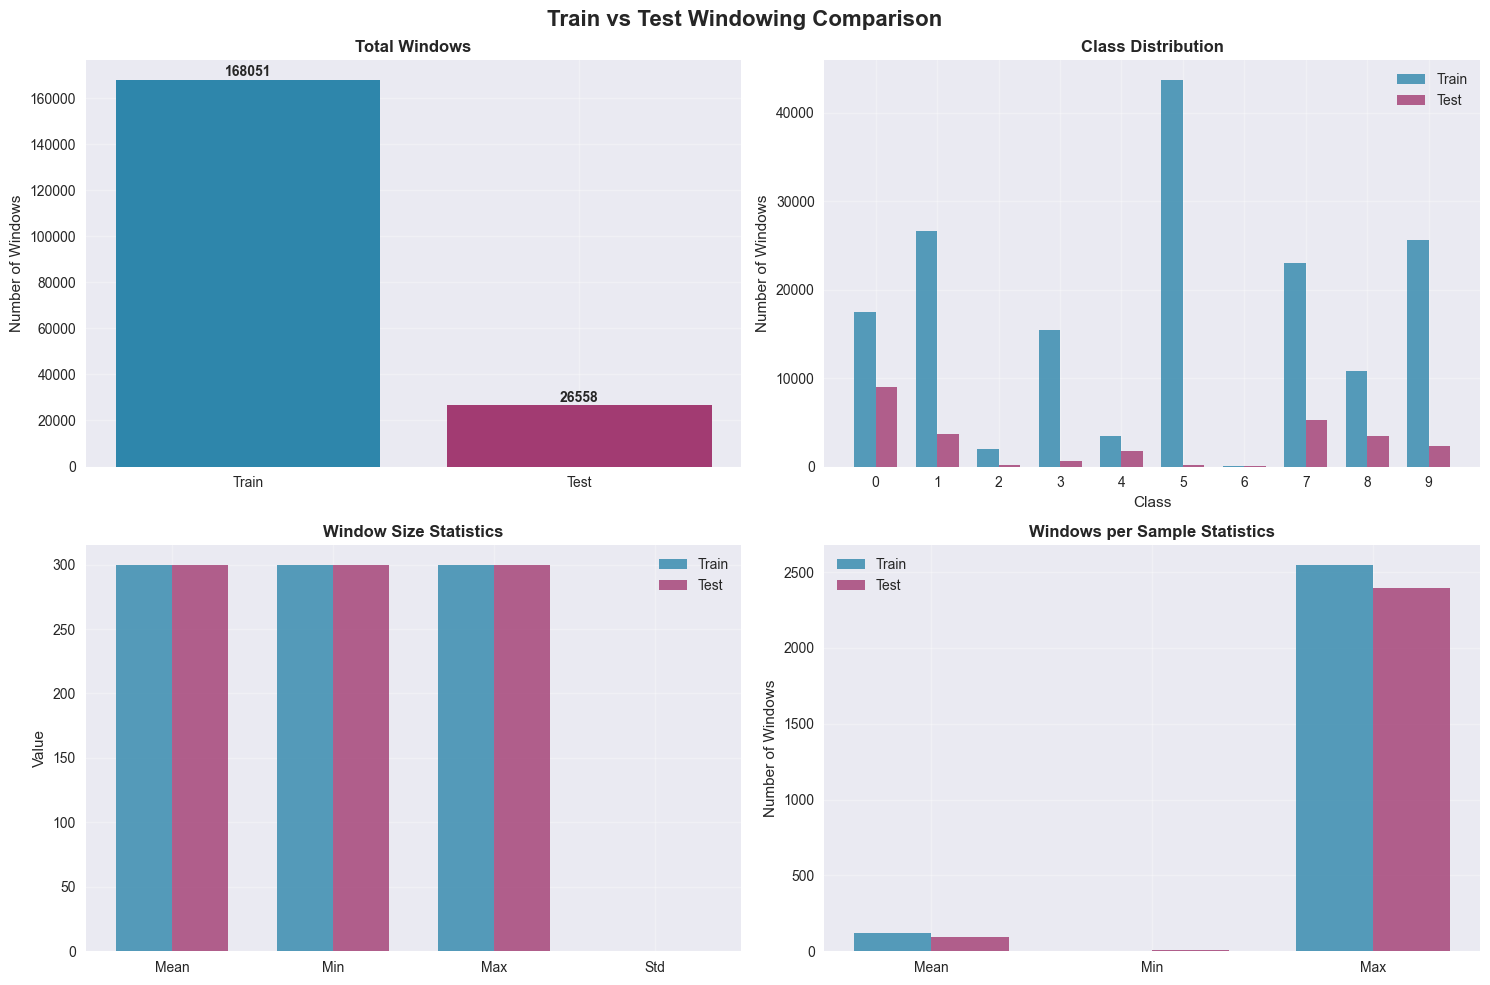

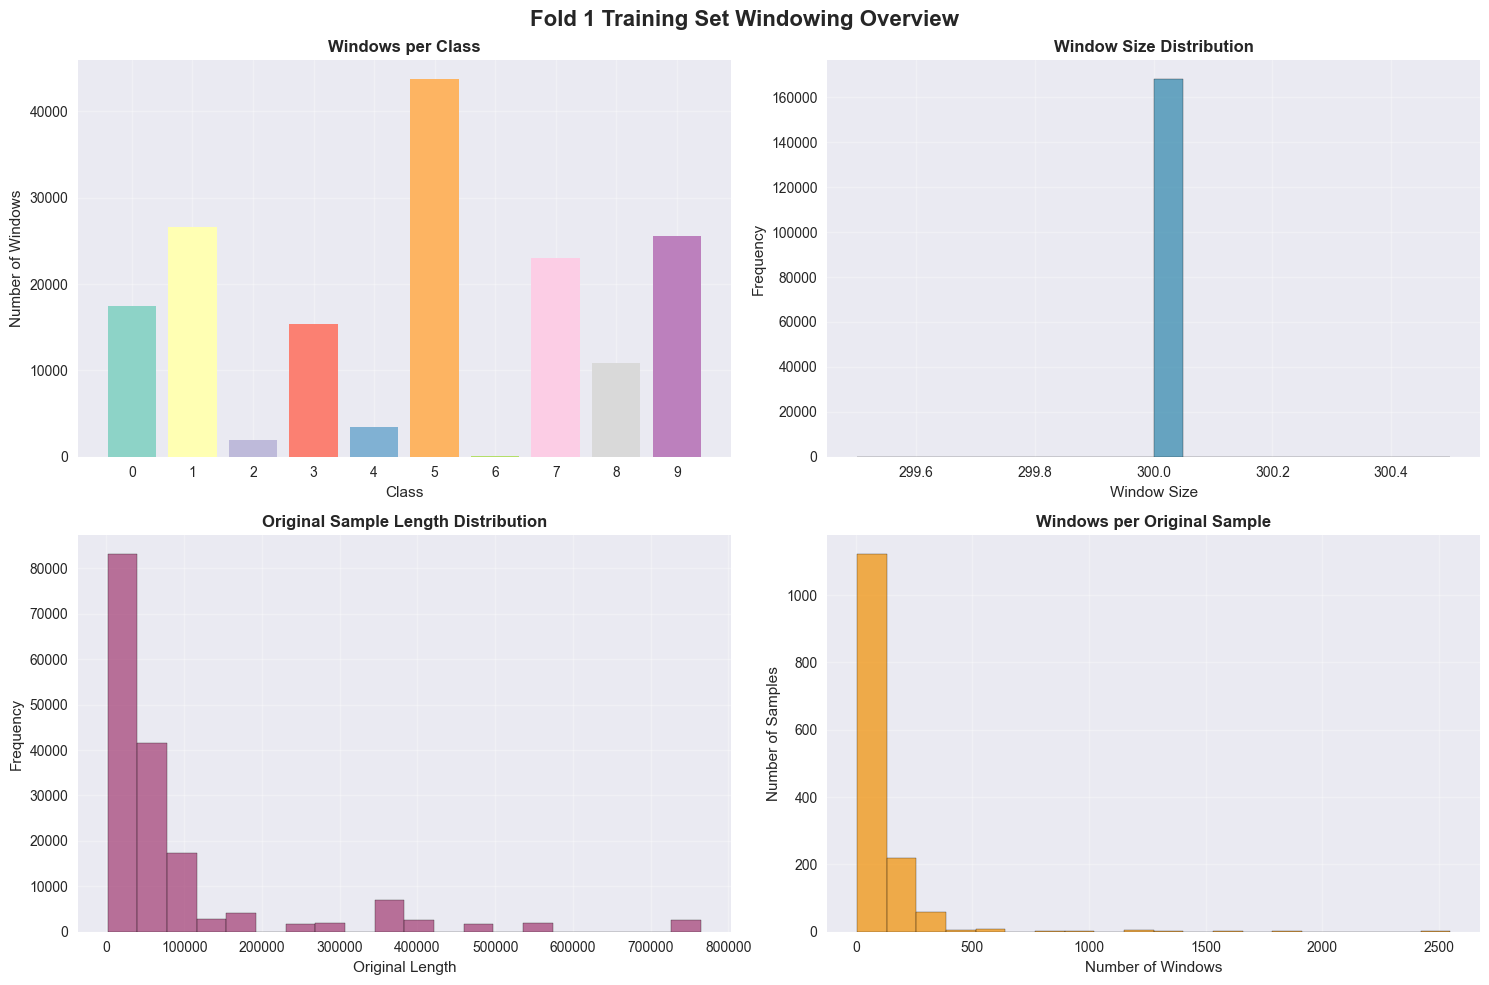


🔍 Showing window examples from Fold 1, training sample 1:
   Original sample length: 17874
   Number of windows created: 59
   Using config columns: P-TPT, T-TPT


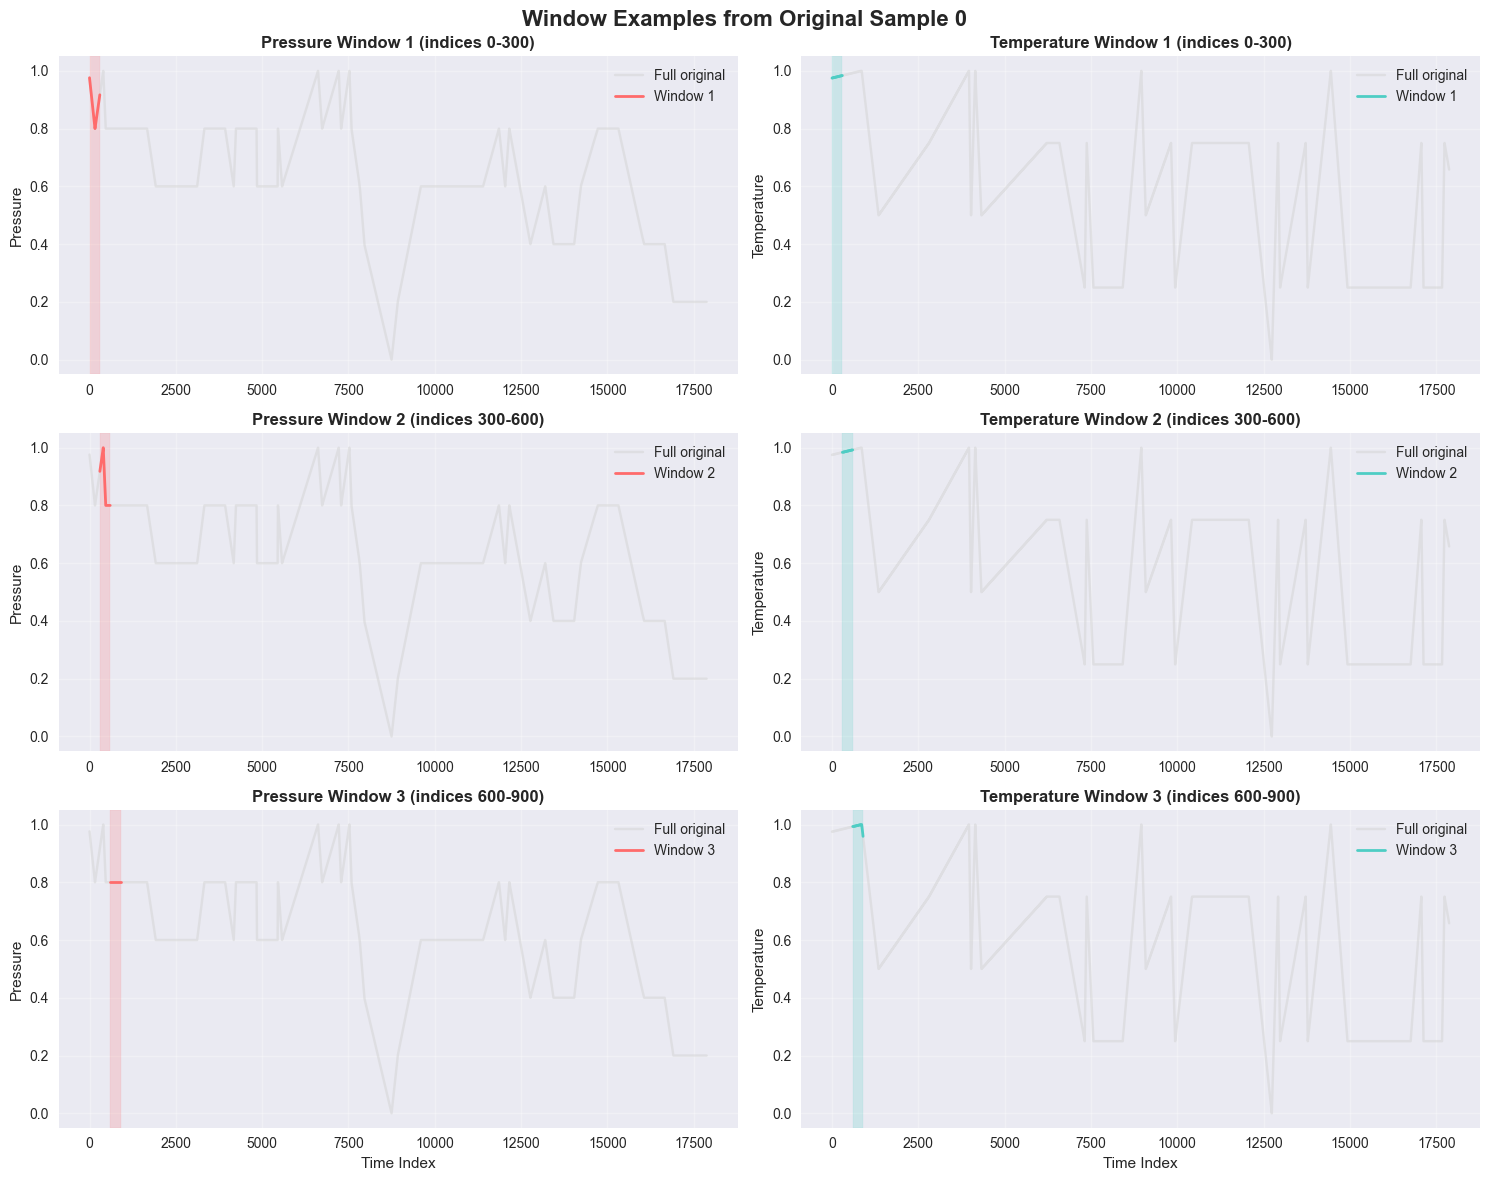


📊 Cross-Fold Windowing Summary:
   Fold 1: 168051 train windows, 26558 test windows
   Fold 2: 170357 train windows, 24252 test windows
   Fold 3: 166928 train windows, 27681 test windows

📈 Average per fold:
   • Training windows: 168445.3
   • Test windows: 26163.7


In [13]:
# Visualize windowing results from Fold 1
print("\n📈 Creating Windowing Visualizations (Fold 1 Example)")
print("-" * config.SEPARATOR_LENGTH)

# Get Fold 1 data for visualization
fold_1_data = all_windowed_folds[0]
fold_1_windowing = fold_1_data["windowing_results"]

# Plot windowing comparison between train and test for Fold 1
visualizer.plot_windowing_comparison(
    fold_1_windowing["train_statistics"], fold_1_windowing["test_statistics"]
)

# Show windowing overview for Fold 1 training data
fold_1_train_metadata = fold_1_windowing["train_metadata"]
if fold_1_train_metadata:
    visualizer.plot_windowing_overview(
        fold_1_train_metadata, "Fold 1 Training Set Windowing Overview"
    )

# Show example windows from Fold 1 first training sample
fold_1_original_train_dfs = fold_1_data["original_fold"]["train_dfs"]
fold_1_train_windowed_dfs = fold_1_data["train_windowed_dfs"]

if fold_1_original_train_dfs and fold_1_train_windowed_dfs:
    # Find windows that come from the first training sample of Fold 1
    sample_0_windows = []
    sample_0_metadata = []

    for i, metadata in enumerate(fold_1_train_metadata):
        if metadata["original_sample_id"] == 0:  # First training sample
            sample_0_windows.append(fold_1_train_windowed_dfs[i])
            sample_0_metadata.append(metadata)

    if sample_0_windows and sample_0_metadata:
        print(f"\n🔍 Showing window examples from Fold 1, training sample 1:")
        print(f"   Original sample length: {sample_0_metadata[0]['original_length']}")
        print(f"   Number of windows created: {len(sample_0_windows)}")
        print(
            f"   Using config columns: {config.PRESSURE_COLUMN}, {config.TEMPERATURE_COLUMN}"
        )

        # Plot window examples using config column names
        visualizer.plot_window_examples(
            original_df=fold_1_original_train_dfs[0],
            windowed_dfs=sample_0_windows[:3],  # Show first 3 windows
            window_metadata=sample_0_metadata[:3],
            num_examples=min(3, len(sample_0_windows)),
            pressure_col=config.PRESSURE_COLUMN,  # Will auto-detect scaled version
            temp_col=config.TEMPERATURE_COLUMN,  # Will auto-detect scaled version
        )

# Display summary statistics across all folds
print(f"\n📊 Cross-Fold Windowing Summary:")
print("=" * 50)
for i, fold_data in enumerate(all_windowed_folds):
    fold_num = fold_data["fold_number"]
    train_windows = len(fold_data["train_windowed_dfs"])
    test_windows = len(fold_data["test_windowed_dfs"])
    print(
        f"   Fold {fold_num}: {train_windows} train windows, {test_windows} test windows"
    )

# Calculate average windows per fold
avg_train_windows = total_train_windows / len(all_windowed_folds)
avg_test_windows = total_test_windows / len(all_windowed_folds)
print(f"\n📈 Average per fold:")
print(f"   • Training windows: {avg_train_windows:.1f}")
print(f"   • Test windows: {avg_test_windows:.1f}")

## 💾 Step 7: Save Processed Data for Training Notebooks

Save all processed cross-validation splits, windowed data, and metadata to disk for use in training notebooks. This ensures reproducible experiments and efficient data loading.

In [ ]:
# ============================================================
# STEP 7: SAVE PROCESSED DATA FOR TRAINING NOTEBOOKS
# ============================================================
print("=" * config.PROGRESS_SEPARATOR_LENGTH)
print("STEP 7: SAVE PROCESSED DATA FOR TRAINING NOTEBOOKS")
print("=" * config.PROGRESS_SEPARATOR_LENGTH)

# Import data persistence utilities
from src.data_persistence import DataPersistence, save_complete_pipeline
import os

print("💾 Initializing Data Persistence System")
print("-" * config.SEPARATOR_LENGTH)

# Check if we have all necessary data to save
required_vars = ["cv_folds", "all_windowed_folds"]
missing_vars = [var for var in required_vars if var not in locals()]

if missing_vars:
    print(f"⚠️ Missing required variables: {missing_vars}")
    print("   Please run the cross-validation and windowing steps first")
    print("   Continuing with available data...")

    # Create placeholder data if needed
    if "cv_folds" not in locals():
        print("   • Creating placeholder for cv_folds")
        cv_folds = []
    if "all_windowed_folds" not in locals():
        print("   • Creating placeholder for all_windowed_folds")
        all_windowed_folds = []
        windowing_results = {
            "train_windowed_dfs": [],
            "train_windowed_classes": [],
            "test_windowed_dfs": [],
            "test_windowed_classes": [],
            "train_statistics": {},
            "test_statistics": {},
        }

# Configure save directory
save_dir = config.PROCESSED_DATA_DIR
print(f"📁 Save directory: {save_dir}")
print(f"📋 Save format: {config.SAVE_FORMAT}")

# Prepare enhanced processing configuration for metadata
processing_config = {
    "target_features": config.TARGET_FEATURES,
    "scaling_method": config.DEFAULT_SCALING_METHOD,
    "n_folds": config.N_FOLDS,
    "window_size": config.WINDOW_SIZE,
    "window_stride": config.WINDOW_STRIDE,
    "min_window_size": config.MIN_WINDOW_SIZE,
    "random_seed": config.RANDOM_SEED,
    "cv_random_state": config.CV_RANDOM_STATE,
    "pressure_column": config.PRESSURE_COLUMN,
    "temperature_column": config.TEMPERATURE_COLUMN,
    "class_column": config.CLASS_COLUMN,
    "processing_notebook": "Data Treatment.ipynb",
    "toolkit_version": "1.0.0",
    "windowing_applied_to_all_folds": True,
    "total_windowed_folds": len(all_windowed_folds),
    "total_train_windows": total_train_windows,
    "total_test_windows": total_test_windows,
}

print(f"\n📊 Data to be saved:")
print(f"   • Cross-validation folds: {len(cv_folds)}")
print(f"   • Windowed folds: {len(all_windowed_folds)}")
print(f"   • Total training windows: {total_train_windows}")
print(f"   • Total test windows: {total_test_windows}")

# Prepare windowing results structure for saving (includes all folds)
extended_windowing_results = {
    "all_windowed_folds": all_windowed_folds,
    "default_fold_results": windowing_results,  # Fold 1 for compatibility
    "total_train_windows": total_train_windows,
    "total_test_windows": total_test_windows,
    "windowing_config": {
        "window_size": config.WINDOW_SIZE,
        "window_stride": config.WINDOW_STRIDE,
        "min_window_size": config.MIN_WINDOW_SIZE,
    },
}

STEP 7: SAVE PROCESSED DATA FOR TRAINING NOTEBOOKS
💾 Initializing Data Persistence System
--------------------------------------------------
📁 Save directory: processed_data
📋 Save format: pickle
🗜️ Compression: snappy

📊 Data to be saved:
   • Cross-validation folds: 3
   • Windowed folds: 3
   • Total training windows: 505336
   • Total test windows: 78491


In [15]:
processing_config

{'target_features': ['P-PDG', 'P-TPT', 'T-TPT', 'class'],
 'scaling_method': 'minmax',
 'n_folds': 3,
 'window_size': 300,
 'window_stride': 300,
 'min_window_size': 300,
 'random_seed': 42,
 'cv_random_state': 42,
 'pressure_column': 'P-TPT',
 'temperature_column': 'T-TPT',
 'class_column': 'class',
 'processing_notebook': 'Data Treatment.ipynb',
 'toolkit_version': '1.0.0',
 'windowing_applied_to_all_folds': True,
 'total_windowed_folds': 3,
 'total_train_windows': 505336,
 'total_test_windows': 78491}

In [ ]:
# ============================================================
# SAVE OPERATION WITH PICKLE FORMAT FOR FAST LOADING
# ============================================================
print("🔄 Saving Data with Pickle Format for Fast Loading")
print("=" * 60)

# Re-import the updated config and data persistence module
import importlib
import src.config
import src.data_persistence

importlib.reload(src.config)
importlib.reload(src.data_persistence)
from src.data_persistence import DataPersistence, save_complete_pipeline

from src import config

print(f"⚡ Using format: {config.SAVE_FORMAT} (for fastest loading)")
print(f"📁 Save directory: {config.PROCESSED_DATA_DIR}")

try:
    # Use the complete pipeline save function with pickle format
    print("💾 Saving with pickle format for maximum speed...")
    saved_dir = save_complete_pipeline(
        cv_folds=cv_folds,
        windowing_results=extended_windowing_results,
        processing_config=processing_config,
        base_dir=save_dir,
    )

    print(f"\n✅ All data saved successfully in pickle format!")
    print(f"📂 Base directory: {saved_dir}")

    # Get and display save summary
    persistence = DataPersistence(base_dir=saved_dir, verbose=False)
    save_summary = persistence.get_save_summary()

    print(f"\n📊 Save Summary:")
    print(f"   • Total files: {save_summary['total_files']}")
    print(f"   • Total size: {save_summary['total_size_mb']:.2f} MB")
    print(f"   • CV folds: {len(cv_folds)} folds")
    print(f"   • Windowed folds: {len(all_windowed_folds)} folds")
    print(f"   • File format: {config.SAVE_FORMAT} (fast loading)")

    if all_windowed_folds:
        print(f"   • Training windows (all folds): {total_train_windows}")
        print(f"   • Test windows (all folds): {total_test_windows}")


except Exception as e:
    print(f"❌ Error saving data: {str(e)}")
    print(f"\n🔍 Debugging info:")
    print(f"   • Save format: {config.SAVE_FORMAT}")
    print(
        f"   • extended_windowing_results keys: {list(extended_windowing_results.keys())}"
    )
    if "all_windowed_folds" in extended_windowing_results:
        print(
            f"   • Number of windowed folds: {len(extended_windowing_results['all_windowed_folds'])}"
        )
        if extended_windowing_results["all_windowed_folds"]:
            first_fold = extended_windowing_results["all_windowed_folds"][0]
            print(f"   • First fold keys: {list(first_fold.keys())}")

    # Show traceback for debugging
    import traceback

    traceback.print_exc()

🔄 Saving Data with Pickle Format for Fast Loading
⚡ Using format: pickle (for fastest loading)
📁 Save directory: processed_data
💾 Saving with pickle format for maximum speed...
📁 Created directory structure in: processed_data
💾 Saving Cross-Validation Folds
--------------------------------------------------
   📁 Fold 1:
      • Training: 1427 samples → processed_data\cv_splits\raw\fold_1\train_data.pickle
      • Testing: 287 samples → processed_data\cv_splits\raw\fold_1\test_data.pickle
      • Metadata: processed_data\cv_splits\raw\fold_1\fold_metadata.json
   📁 Fold 2:
      • Training: 1427 samples → processed_data\cv_splits\raw\fold_2\train_data.pickle
      • Testing: 287 samples → processed_data\cv_splits\raw\fold_2\test_data.pickle
      • Metadata: processed_data\cv_splits\raw\fold_2\fold_metadata.json
   📁 Fold 3:
      • Training: 1428 samples → processed_data\cv_splits\raw\fold_3\train_data.pickle
      • Testing: 286 samples → processed_data\cv_splits\raw\fold_3\test_data.